In [1]:
import numpy as np
import scipy.stats as sps
import pandas as pd
from gaussian_mixture_anomaly_detection import GaussianMixtureInTimeAnomalyDetector
from gaussian_mixture_anomaly_detection import extract_anomaly_target
import matplotlib.pyplot as plt
%matplotlib inline

простой пример: 10 двумерных временных рядов по 10 элементов в каждом,лежащие на 3x=2y со случайным нормальным смещением, а также 4 аномальные точки

In [2]:
T = 10
F = 40
N = 2

data = np.zeros((F, T, N))

for i in range(F):
    for t in range(T):
        data[i][t] = np.array([2,3]) * t + sps.norm.rvs(size=2,scale=0.5)
        
anomalies = [(0,5,0), (1,3,1), (1,4,1), (2,8,1), (3,2,0)]
for a in anomalies:
    data[a[0]][a[1]][a[2]] += 5

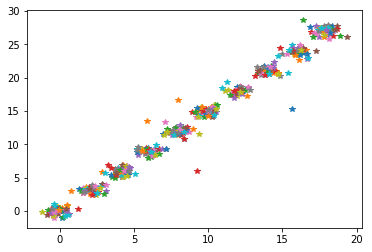

In [3]:
for i in range(F):
    plt.plot(data[i][:, 0], data[i][:, 1], '*')

In [4]:
detector = GaussianMixtureInTimeAnomalyDetector(n_components=10, random_state=1)

In [5]:
scores = detector.fit(data)  # scores  - лограифмическое правдоподобие нормальности для каждого сэмпла

Start probabilities memorization


NameError: name 'tqdm' is not defined

выявление аномальных сэмплов:

In [ ]:
detector.find_anomalies(scores, log_likelihood_threshold=0)

In [ ]:
detector.find_anomalies(scores, anomaly_top=0.05)

как видно аномалии попали в топ 5%

In [ ]:
detector.find_anomalies(scores, anomaly_top=0.1, strategy='series')

2 ряда с добавленными аномалиями попали в топ по сумме логорифимических правдоподобий

In [ ]:
for f in range(F):
    plt.plot(range(T), scores[f],'*')
    plt.plot([-1, 10], [0,0],'r')
    plt.xlim([-0.5, 9.5])
    plt.show()

In [ ]:
smoothed_scores = detector.smoothed_sample_anomalies(scores, halflife=2)

In [ ]:
for f in range(F):
    plt.plot(range(T), smoothed_scores[f],'*')
    plt.plot([-1, 10], [0,0],'r')
    plt.xlim([-0.5, 9.5])
    plt.show()

In [ ]:
targets =  extract_anomaly_target(pd.DataFrame(data.reshape(40 * 10, 2)), 40, 1, 2, 10, 0.01)
smoothed_scores = detector.smoothed_sample_anomalies(scores)

In [ ]:
targets2d = targets.reshape((40,10))
for f in range(F):
    plt.plot(range(T), smoothed_scores[f],'*')
    plt.plot([-1, 10], [0,0],'r')
    plt.xlim([-0.5, 9.5])
    plt.show()
    print(targets2d[f])